In [5]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!pip install openpyxl

from sklearn.preprocessing import MinMaxScaler
df_ = pd.read_excel("../input/online-retail-ii/online_retail_II.xlsx",sheet_name="Year 2010-2011")
df=df_.copy()
df.head()


     |████████████████████████████████| 242 kB 5.0 MB/s            


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
# Preparing the Data 
df=df[~df["Invoice"].astype(str).str.contains("C",na=False)]
df=df[(df["Quantity"]>0)]
df.dropna(inplace=True)
df["TotalPrice"]=df["Quantity"]*df["Price"]

cltv_df= df.groupby("Customer ID").agg({"Invoice":lambda x: len(x),"Quantity":lambda x: x.sum(),"TotalPrice":lambda x:x.sum()})
cltv_df.columns=['total_transaction','total_unit','total_price']
cltv_df.head()


,total_transaction,total_unit,total_price
Customer ID,,,
12346.0,1,74215,77183.60
12347.0,182,2458,4310.00
12348.0,31,2341,1797.24
12349.0,73,631,1757.55
12350.0,17,197,334.40


In [7]:
##################################################
# 1. Calculate Average Order Value
##################################################

# CLTV = (Customer_Value / Churn_Rate) x Profit_margin.
# Customer_Value = Average_Order_Value * Purchase_Frequency
# Average_Order_Value = Total_Revenue / Total_Number_of_Orders ( Earnings Per Unit )
# Purchase_Frequency =  Total_Number_of_Orders / Total_Number_of_Customers
# Churn_Rate = 1 - Repeat_Rate
# Profit_margin

cltv_df["avg_order_value"]=cltv_df["total_price"]*cltv_df["total_transaction"] # greater is the better value
cltv_df["avg_order_value"].head()


Customer ID
12346.0     77183.60
12347.0    784420.00
12348.0     55714.44
12349.0    128301.15
12350.0      5684.80
Name: avg_order_value, dtype: float64

In [8]:
##################################################
# 2. Calculate Purchase Frequency
##################################################

cltv_df.shape[0]
cltv_df["purchase_frequency"]=cltv_df["total_transaction"]/cltv_df.shape[0]
cltv_df["purchase_frequency"].head(10)

Customer ID
12346.0    0.000230
12347.0    0.041945
12348.0    0.007145
12349.0    0.016824
12350.0    0.003918
12352.0    0.019590
12353.0    0.000922
12354.0    0.013367
12355.0    0.002996
12356.0    0.013598
Name: purchase_frequency, dtype: float64

In [9]:
# repeat rate is the the number of customers who shopped at least 2 times in the dataset divided by the total number of customers
repeat_rate=cltv_df[cltv_df.total_transaction>1].shape[0]/cltv_df.shape[0]
#so the repeat_rate is 0.978442280945758
churn_rate = 1 - repeat_rate
churn_rate


0.016593685180917306

In [10]:
# We assume 5% profit from the total price and since it is unique for each customer, 
# we add this dataset, profit margin to this dataset.
cltv_df["profit_margin"]=cltv_df["total_price"]*0.05
cltv_df["profit_margin"].head()

Customer ID
12346.0    3859.1800
12347.0     215.5000
12348.0      89.8620
12349.0      87.8775
12350.0      16.7200
Name: profit_margin, dtype: float64

In [11]:
# CLTV = (Customer_Value / Churn_Rate) x Profit_margin.
# Customer_Value = Average_Order_Value * Purchase_Frequency
cltv_df['CV']=(cltv_df['avg_order_value']/cltv_df['purchase_frequency'])/churn_rate
cltv_df['CLTV']=cltv_df['CV']*cltv_df["profit_margin"]

pd.set_option('display.float_format', lambda x: '%.5f' % x)
cltv_df.sort_values("CLTV",ascending=False).head()

,total_transaction,total_unit,total_price,avg_order_value,purchase_frequency,profit_margin,CV,CLTV
Customer ID,,,,,,,,
14646.00000,2080,197491,280206.02000,582828521.60000,0.47937,14010.30100,73269675031.45009,1026530201362800.25000
18102.00000,431,64124,259657.30000,111912296.30000,0.09933,12982.86500,67896492696.85121,881490998656705.25000
17450.00000,337,69993,194550.79000,65563616.23000,0.07767,9727.53950,50872116025.24416,494860518084145.56250
16446.00000,3,80997,168472.50000,505417.50000,0.00069,8423.62500,44053034002.39571,371086238548430.62500
14911.00000,5677,80515,143825.06000,816494865.62000,1.30837,7191.25300,37608097811.67018,270449346212466.65625


In [12]:
# to make more understandable and readable lets transform it

scaler=MinMaxScaler(feature_range=(1,100))
scaler.fit(cltv_df[["CLTV"]])
cltv_df["SCALED_CLTV"]=scaler.transform(cltv_df[["CLTV"]])
cltv_df.sort_values("CLTV",ascending=False)
pd.set_option('display.max_columns',20)
cltv_df[["total_transaction","total_unit","total_price","CLTV","SCALED_CLTV"]].sort_values(by="CLTV",ascending=False).head()

,total_transaction,total_unit,total_price,CLTV,SCALED_CLTV
Customer ID,,,,,
14646.00000,2080,197491,280206.02000,1026530201362800.25000,100.00000
18102.00000,431,64124,259657.30000,881490998656705.25000,86.01222
17450.00000,337,69993,194550.79000,494860518084145.56250,48.72504
16446.00000,3,80997,168472.50000,371086238548430.62500,36.78807
14911.00000,5677,80515,143825.06000,270449346212466.65625,27.08251


In [13]:
cltv_df.sort_values("total_price",ascending=False)
cltv_df["segment"]=pd.qcut(cltv_df["SCALED_CLTV"],4,labels=['D','C','B','A'])
cltv_df[["segment", "total_transaction", "total_unit", "total_price", "CLTV", "SCALED_CLTV"]].sort_values(
    by="SCALED_CLTV",
    ascending=False).head()

,segment,total_transaction,total_unit,total_price,CLTV,SCALED_CLTV
Customer ID,,,,,,
14646.00000,A,2080,197491,280206.02000,1026530201362800.25000,100.00000
18102.00000,A,431,64124,259657.30000,881490998656705.25000,86.01222
17450.00000,A,337,69993,194550.79000,494860518084145.56250,48.72504
16446.00000,A,3,80997,168472.50000,371086238548430.62500,36.78807
14911.00000,A,5677,80515,143825.06000,270449346212466.65625,27.08251


In [14]:
cltv_df.groupby('segment')[["total_transaction", "total_unit", "total_price", "CLTV", "SCALED_CLTV"]].agg(
    {"count","mean","sum"})

total_transaction                   total_unit                      \
                    count      mean     sum      count       mean      sum   
segment                                                                      
D                    1085  17.21843   18682       1085  129.48664   140493   
C                    1085  36.97880   40122       1085  286.29677   310632   
B                    1084  76.43542   82856       1084  649.44188   703995   
A                    1085 236.18894  256265       1085 3711.13088  4026577   

        total_price                           CLTV                      \
              count       mean           sum count                mean   
segment                                                                  
D              1085  178.92174  194130.09000  1085     487712625.18090   
C              1085  464.36576  503836.85200  1085    2977954454.14462   
B              1084 1071.87575 1161913.31100  1084   16060882877.95347   
A              1085 6499.12042 7051545.65100  1085 4424085101843.53320   

                               SCALED_CLTV                     
                           sum       count    mean        sum  
segment                                                        
D           529168198321.27588        1085 1.00005 1085.05103  
C          3231080582746.90723        1085 1.00029 1085.31161  
B         17409997039701.56055        1084 1.00155 1085.67904  
A       4800132335500234.00000        1085 1.42666 1547.93144

In [15]:
# In cltv beta beta and gamma beta models used to predict how many purchases customers will make in a given time period

In [16]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!pip install openpyxl

from sklearn.preprocessing import MinMaxScaler


In [17]:
!pip install lifetimes

     |████████████████████████████████| 584 kB 4.1 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for autograd: filename=autograd-1.3-py3-none-any.whl size=47989 sha256=1cea9d8905f04d29993066e79fcdf98bcf55aa19da841d052144213ea91b9f56
  Stored in directory: /root/.cache/pip/wheels/ef/32/31/0e87227cd0ca1d99ad51fbe4b54c6fa02afccf7e483d045e04
Successfully built autograd


In [18]:
# if we interpret it according to the monthly, there is only one thing to keep in mind in the formulation we see:
#The average number of orders per month and how much people leave in these orders
#If we have the information, we can calculate lifetime data in this way.
# There is a motto of `buy till you die / sell till you buy`

# As long as they are Alive, this customers will continue to make random purchases around
#the transaction rate/ as a result, the transaction rate

# and drop rates are also important
#We can make time projection prediction with cltv formula

In [19]:
################################################ ############
# CLTV Prediction with BG-NBD and Gamma-Gamma
################################################ ############

# CLTV in 4 Steps

#1. Data Preparation
#2. Calculate Expected Sale Forecasting values with BG-NBD Model.
# 3. Calculate Expected Average Profit values with the Gamma-Gamma Model.
# 4. Calculate CLTV for a given time period with BG-NBD and Gamma-Gamma models.


# Let's remember the previous formula:
# CLTV = (Customer_Value / Churn_Rate) x Profit_margin.
# Customer_Value = Average_Order_Value * Purchase_Frequency

################################################ ############
# PROJECT: Estimate CLTV using BGNBD and GG Models.
################################################ ############

################################################ ############
# TASK 1
################################################ ############
# - Make a 6-month CLTV prediction for 2010-2011 UK customers.

# - Interpret and evaluate the results you have obtained.
# - Highlight results that you think are illogical or too accurate.
# - Attention! We expect cltv prediction to be made, not 6-month expected sales.
# So continue by installing the bgnbd and gamma models directly and
# - Enter 6 in the month section for cltv prediction.

In [20]:
##############################################################
# 1. Data Preperation
##############################################################
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)


def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [21]:
df_ = pd.read_excel("../input/online-retail-ii/online_retail_II.xlsx",sheet_name="Year 2010-2011")
df=df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55000,17850.00000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75000,17850.00000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541910.00000,9.55223,218.08096,-80995.00000,1.00000,3.00000,10.00000,80995.00000
Price,541910.00000,4.61114,96.75977,-11062.06000,1.25000,2.08000,4.13000,38970.00000
Customer ID,406830.00000,15287.68416,1713.60307,12346.00000,13953.00000,15152.00000,16791.00000,18287.00000


In [24]:
df.dropna(inplace=True)
df = df[~df["Invoice"].str.contains("C", na=False)]
df=df[df["Quantity"]>0]
replace_with_thresholds(df,"Quantity")
replace_with_thresholds(df,"Price")
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397925.00000,11.83371,25.53449,1.00000,2.00000,6.00000,12.00000,298.50000
Price,397925.00000,2.89320,3.22714,0.00000,1.25000,1.95000,3.75000,37.06000
Customer ID,397925.00000,15294.30860,1713.17274,12346.00000,13969.00000,15159.00000,16795.00000,18287.00000


In [25]:
df["TotalPrice"]=df["Quantity"]*df["Price"]

df["InvoiceDate"].max()

today_date=dt.datetime(2011,12,11)

In [26]:

#############################################
# RFM Table
#############################################

df = df.loc[:,~df.columns.duplicated()]

## recency kullanıcıya özel dinamik.
rfm=df.groupby("Customer ID").agg({'InvoiceDate':[lambda date:(date.max()-date.min()).days,
                                                  lambda date:(today_date-date.min()).days],
                                  'Invoice':lambda num: num.nunique(),
                                   'TotalPrice':lambda TotalPrice:TotalPrice.sum()})

rfm.head()



InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.00000           0        326        1  310.44000
12347.00000         365        368        7 4310.00000
12348.00000         282        359        4 1770.78000
12349.00000           0         19        1 1491.72000
12350.00000           0        311        1  331.46000

In [27]:
rfm.columns=rfm.columns.droplevel(0)
rfm.head()



,<lambda_0>,<lambda_1>,<lambda>,<lambda>
Customer ID,,,,
12346.00000,0,326,1,310.44000
12347.00000,365,368,7,4310.00000
12348.00000,282,359,4,1770.78000
12349.00000,0,19,1,1491.72000
12350.00000,0,311,1,331.46000


In [28]:
## recency_cltv_p
rfm.columns = ['recency_cltv_p', 'T', 'frequency', 'monetary']
rfm.head()

,recency_cltv_p,T,frequency,monetary
Customer ID,,,,
12346.00000,0,326,1,310.44000
12347.00000,365,368,7,4310.00000
12348.00000,282,359,4,1770.78000
12349.00000,0,19,1,1491.72000
12350.00000,0,311,1,331.46000


In [29]:
## simplified monetary_avg
rfm["monetary"] =rfm["monetary"]/rfm["frequency"]
rfm["monetary"].head()





Customer ID
12346.00000    310.44000
12347.00000    615.71429
12348.00000    442.69500
12349.00000   1491.72000
12350.00000    331.46000
Name: monetary, dtype: float64

In [30]:
rfm.rename(columns={"monetary": "monetary_avg"}, inplace=True)
rfm.head()

,recency_cltv_p,T,frequency,monetary_avg
Customer ID,,,,
12346.00000,0,326,1,310.44000
12347.00000,365,368,7,615.71429
12348.00000,282,359,4,442.69500
12349.00000,0,19,1,1491.72000
12350.00000,0,311,1,331.46000


In [31]:
# CALCULATION OF WEEKLY RECENCY AND WEEKLY T for BGNBD
## recency_weekly_p
rfm["recency_weekly_p"] = rfm["recency_cltv_p"]/7
rfm["T_weekly"] =rfm["T"]/7

# CONTROLLING
rfm = rfm[(rfm["monetary_avg"]>0) ]

## freq > 1
rfm = rfm[(rfm['frequency']>1)]
rfm["frequency"] = rfm["frequency"].astype(int)
rfm.head()

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly
Customer ID,,,,,,
12347.00000,365,368,7,615.71429,52.14286,52.57143
12348.00000,282,359,4,442.69500,40.28571,51.28571
12352.00000,260,297,8,219.54250,37.14286,42.42857
12356.00000,302,326,3,937.14333,43.14286,46.57143
12358.00000,149,151,2,575.21000,21.28571,21.57143


In [32]:
################################################ ############
# 2. Establishing BG/NBD Model (probabilistic model. all users purchase.drop rate and
#Considering #transaction rates, you can learn the structure and send it to a specific customer.
#It will be revealed when we ask the #customer's values to the model
#we use it to predict sales )
################################################ ############

# pip install lifetimes
#x number of transactions, ie frequency
# t_x : recency
# T: customer. It can be called tenure.

bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(rfm['frequency'],
         rfm['recency_weekly_p'],
         rfm['T_weekly'])

#Our model is now fit and has found the distributions, so we can continue to perform the operations.
#2893 subject var / containing distributions of transaction rates and drop rates
#distribution parameters: a: 1.93, alpha: 9.47, b: 6.27, r: 2.22>

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.40, b: 2.49, r: 2.18>

In [33]:
################################################ ##############
# Who are the 10 customers we expected them to purchase the most, in 1 week?
################################################ ##############

#Expected value allows us to project. Bgf model learned over time and we asked customers for their learning.
#We modeled with our #bgf object and it contains the distribution information.

bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        rfm['frequency'],
                                                        rfm['recency_weekly_p'],
                                                        rfm['T_weekly']).sort_values(ascending=False).head(10)
#or

rfm["expected_number_of_purchases"] =bgf.predict(1,
                                                  rfm['frequency'],
                                                  rfm['recency_weekly_p'],
                                                  rfm['T_weekly'])

rfm.head()

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases
Customer ID,,,,,,,
12347.00000,365,368,7,615.71429,52.14286,52.57143,0.14128
12348.00000,282,359,4,442.69500,40.28571,51.28571,0.09196
12352.00000,260,297,8,219.54250,37.14286,42.42857,0.18240
12356.00000,302,326,3,937.14333,43.14286,46.57143,0.08616
12358.00000,149,151,2,575.21000,21.28571,21.57143,0.12226


In [34]:
################################################################
#  Who are the 10 customers we expected them to purchase the most, in 1 month? (4 week)
################################################################


bgf.predict(4,
            rfm['frequency'],
            rfm['recency_weekly_p'],
            rfm['T_weekly']).sort_values(ascending=False).head(10)

#or

rfm["expected_number_of_purchases"] = bgf.predict(4,
                                                  rfm['frequency'],
                                                  rfm['recency_weekly_p'],
                                                  rfm['T_weekly'])

rfm.sort_values("expected_number_of_purchases", ascending=False).head(20)

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases
Customer ID,,,,,,,
12748.00000,372,374,210,154.19243,53.14286,53.42857,13.02567
14911.00000,372,374,201,691.71010,53.14286,53.42857,12.47310
17841.00000,371,374,124,330.13435,53.00000,53.42857,7.74034
13089.00000,366,370,97,606.36247,52.28571,52.85714,6.13346
14606.00000,372,374,93,130.13903,53.14286,53.42857,5.84027
15311.00000,373,374,91,667.77912,53.28571,53.42857,5.71947
12971.00000,368,373,86,127.48587,52.57143,53.28571,5.41348
14646.00000,353,355,74,3596.80439,50.42857,50.71429,4.87636
13408.00000,371,374,62,453.50065,53.00000,53.42857,3.93437


In [35]:


################################################################
#  What is the Expected Number of Sales of the Whole Company in 1 Month?
################################################################

bgf.predict(4,
            rfm['frequency'],
            rfm['recency_weekly_p'],
            rfm['T_weekly']).sum()



1777.1450731636942

In [36]:
################################################################
# What is the Expected Number of Sales of the Whole Company in 3 Months?
################################################################


bgf.predict(4*3,
            rfm['frequency'],
            rfm['recency_weekly_p'],
            rfm['T_weekly']).sum()



5271.849715637092

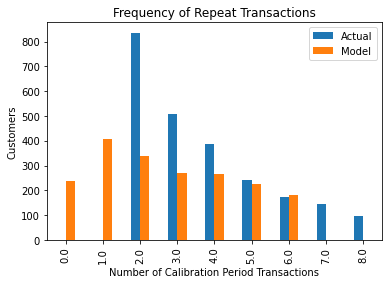

In [37]:
################################################################
#  Evaluation of Forecast Results
################################################################

plot_period_transactions(bgf)
plt.show()

In [38]:
##############################################################
# 3. Establishment of GAMMA-GAMMA Model/ expected_avarage_profit
##############################################################


ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(rfm['frequency'],rfm['monetary_avg'])

ggf.conditional_expected_average_profit(rfm['frequency'],
                                        rfm['monetary_avg']).head(10)





Customer ID
12347.00000    631.91197
12348.00000    463.74554
12352.00000    224.88667
12356.00000    995.99768
12358.00000    631.90095
12359.00000   1435.03722
12360.00000    933.78938
12362.00000    532.23164
12363.00000    304.26377
12364.00000    344.13665
dtype: float64

In [39]:
rfm["expected_average_profit"] = ggf.conditional_expected_average_profit(rfm['frequency'],
                                                                         rfm['monetary_avg'])

rfm.sort_values("expected_average_profit", ascending=False).head(20)

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit
Customer ID,,,,,,,,
12415.00000,313,338,21,5724.30262,44.71429,48.28571,1.51398,5772.17719
12590.00000,0,212,2,4591.17250,0.00000,30.28571,0.04593,5029.40987
12435.00000,188,268,2,3914.94500,26.85714,38.28571,0.30407,4288.93571
12409.00000,103,183,3,3690.89000,14.71429,26.14286,0.46741,3918.80790
14088.00000,312,323,13,3864.55462,44.57143,46.14286,1.03796,3917.12864
18102.00000,366,368,60,3859.73908,52.28571,52.57143,3.86386,3870.99670
12753.00000,339,363,6,3571.56500,48.42857,51.85714,0.50277,3678.57611
14646.00000,353,355,74,3596.80439,50.42857,50.71429,4.87636,3605.30916
15749.00000,97,333,3,3028.78000,13.85714,47.57143,0.11156,3216.04831


In [40]:
##############################################################
# 4. Calculation of CLTV with BG-NBD and GG model.
##############################################################


cltv = ggf.customer_lifetime_value(bgf,
                                   rfm['frequency'],
                                   rfm['recency_weekly_p'],
                                   rfm['T_weekly'],
                                   rfm['monetary_avg'],
                                   time=6, # 6 months
                                    freq="W", # T's frequency information.
                                    discount_rate=0.01)

cltv.head()



Customer ID
12347.00000   2200.75792
12348.00000   1050.35232
12352.00000   1007.74075
12356.00000   2109.55790
12358.00000   1870.55511
Name: clv, dtype: float64

In [41]:
cltv.shape



(2845,)

In [42]:
cltv = cltv.reset_index()
cltv.head()


,Customer ID,clv
0,12347.00000,2200.75792
1,12348.00000,1050.35232
2,12352.00000,1007.74075
3,12356.00000,2109.55790
4,12358.00000,1870.55511


In [43]:
cltv.sort_values(by='clv', ascending=False).head(10)

,Customer ID,clv
1122,14646.00000,108691.79810
2761,18102.00000,92510.27787
843,14096.00000,56135.70048
36,12415.00000,53978.79954
1257,14911.00000,53427.08310
2458,17450.00000,53004.42683
874,14156.00000,45708.06449
2487,17511.00000,37047.56038
2075,16684.00000,26217.82331
650,13694.00000,25301.55817


In [44]:
rfm_cltv_final = rfm.merge(cltv, on="Customer ID", how="left")
rfm_cltv_final.head()

,Customer ID,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit,clv
0,12347.00000,365,368,7,615.71429,52.14286,52.57143,0.56352,631.91197,2200.75792
1,12348.00000,282,359,4,442.69500,40.28571,51.28571,0.36675,463.74554,1050.35232
2,12352.00000,260,297,8,219.54250,37.14286,42.42857,0.72713,224.88667,1007.74075
3,12356.00000,302,326,3,937.14333,43.14286,46.57143,0.34351,995.99768,2109.55790
4,12358.00000,149,151,2,575.21000,21.28571,21.57143,0.48623,631.90095,1870.55511


In [45]:
rfm_cltv_final["clv"].describe().T

count     2845.00000
mean      1667.50690
std       4009.02064
min          0.00000
25%        515.52616
50%        987.21185
75%       1792.54410
max     108691.79810
Name: clv, dtype: float64

In [46]:
# What happens next?
# It is necessary to benchmark according to time with the holdout method.

################################################ ############
# PROJECT: Estimate CLTV using BGNBD and GG Models.
################################################ ############

################################################ ############
# TASK 1
################################################ ############
# - Make a 6-month CLTV prediction for 2010-2011 UK customers.
# - Interpret and evaluate the results you have obtained.
# - Highlight results that you think are illogical or too accurate.
# - Attention! We expect cltv prediction to be made, not 6-month expected sales.
# So continue by installing the bgnbd and gamma models directly and
# - Enter 6 in the month section for cltv prediction.

#MISSION - 1
#Make a 6-month CLTV prediction for 2010-2011 UK customers.
#When the 6-month CLTV values are examined, the customer with ID 18102 has the highest value.
#Recency and Frequency of the customer with ID 17450, whose values I think are close
#CLTV value is lower although the values are almost equal. The reason for this is 18102
#It will be due to the higher Monetary value of the customer with the ID.
#I'm thinking.
#I think that the values of the customer with ID 17450 are close to the values of the customer with ID 17511.
#Although the Monetary value is high, the CLTV value is lower. The reason for this is 17511
# I attribute it to the lower Frequency value of the customer with the ID.

In [47]:
################################################ ############
# TASK 2
################################################ ############
# - Calculate 1-month and 12-month CLTV for 2010-2011 UK customers.
# - Analyze the 10 highest people at 1 month CLTV and the 10 highest at 12 months.
# - Is there a difference? If so, why do you think it could be?
# Attention! There is no need to build a model from scratch.
# cltv can be calculated directly over existing bgf and ggf.

# 1 month
cltv_2= ggf.customer_lifetime_value(bgf,
                                   rfm['frequency'],
                                   rfm['recency_weekly_p'],
                                   rfm['T_weekly'],
                                   rfm['monetary_avg'],
                                   time=1, # 1 months
                                   freq="W" #T in W
                                    )

cltv_2.head()



#Generally, CLTV values ​​of all customers have increased between 1-12 months, but with ID 15311
#customer's Monetary value is almost 1 in 4 customers with 16000 ID.
#It showed a high increase and went up a row.
# When two customers are compared, this may be due to the Frequency values.
#stands out because 15311's Frequency is 91 while 16000's is 3rd.
#However, when customers with similar IDs 17511 and 16684 are examined, Frequency
#The difference between the Monetary values even though the #values are very close to each other CLTV
#It had a huge impact on #values. This situation shows us the effect of Monetary value.

Customer ID
12347.00000   382.85189
12348.00000   182.85799
12352.00000   175.79918
12356.00000   367.83005
12358.00000   330.23620
Name: clv, dtype: float64

In [48]:
rfm_cltv_2 = rfm.merge(cltv_2,on="Customer ID", how="left")

rfm_cltv_2.sort_values(by = "clv", ascending=False).head(10)
rfm_cltv_2.reset_index(inplace=True)
one_month = rfm_cltv_2.head(10)

# 12 months
cltv_3= ggf.customer_lifetime_value(bgf,
                                   rfm['frequency'],
                                   rfm['recency_weekly_p'],
                                   rfm['T_weekly'],
                                   rfm['monetary_avg'],
                                   time=12, # 12 months
                                   freq="W" #T in W
                                    )


cltv_3.head()



Customer ID
12347.00000   4199.74589
12348.00000   2003.20405
12352.00000   1918.90831
12356.00000   4018.35838
12358.00000   3532.23260
Name: clv, dtype: float64

In [49]:
rfm_cltv_3 = rfm.merge(cltv_3,on="Customer ID", how="left")
rfm_cltv_3.sort_values(by = "clv", ascending=False).head(10)
rfm_cltv_3.reset_index(inplace=True)
twelwe_months = rfm_cltv_3.head(10)
twelwe_months

,Customer ID,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit,clv
0,12347.00000,365,368,7,615.71429,52.14286,52.57143,0.56352,631.91197,4199.74589
1,12348.00000,282,359,4,442.69500,40.28571,51.28571,0.36675,463.74554,2003.20405
2,12352.00000,260,297,8,219.54250,37.14286,42.42857,0.72713,224.88667,1918.90831
3,12356.00000,302,326,3,937.14333,43.14286,46.57143,0.34351,995.99768,4018.35838
4,12358.00000,149,151,2,575.21000,21.28571,21.57143,0.48623,631.90095,3532.23260
5,12359.00000,274,332,4,1371.85000,39.14286,47.42857,0.39662,1435.03722,6690.83079
6,12360.00000,148,201,3,878.53333,21.14286,28.71429,0.47625,933.78938,5157.26252
7,12362.00000,292,296,10,522.62300,41.71429,42.28571,0.89301,532.23164,5578.49794
8,12363.00000,132,243,2,276.00000,18.85714,34.71429,0.30111,304.26377,1067.05725
9,12364.00000,104,113,4,328.27500,14.85714,16.14286,0.86463,344.13665,3399.76161


In [51]:
################################################ ############
# TASK 3
################################################ ############
# For 2010-2011 UK customers Divide all your customers into 3 groups (segments) based on 6-month CLTV and
# add the group names to the dataset. For example (C, B, A)
# Select the best 20 percent according to CLTV. And write top_flag to them. 1 to 20 percent.
# write 0 to the others.

# Analyze group 3 in terms of other variables in the data set.
# Make 6-month action suggestions to the management for 3 groups. Short short.

rfm_cltv_final["segment"] = pd.qcut(rfm_cltv_final["clv"], 3, labels=["C", "B", "A"])

# sorted from largest to smallest and got IDs based on 20% of df size
top_20_ids = rfm_cltv_final.sort_values(by="clv", ascending=False)[:int(rfm_cltv_final.shape[0] / 100 * 20)][
"Customer ID"]



# Top_flag has been created for these IDs and assigned 1-0
rfm_cltv_final["top_flag"] = rfm_cltv_final["Customer ID"].apply(lambda x: 1 if x in top_20_ids.values else 0)




rfm_cltv_final.sort_values(by="clv", ascending=False).head()
rfm_cltv_final.sort_values(by="clv", ascending=True).head()

#A segment contains top_flag variables that contain the top 20% of CLTV values.
# hosts. This makes the customers in the A segment important.
#In general, when looking at the A segment, it is seen that the Recency and T values are quite high.
# is observed. If we can increase the Frequency values of these customers, this will help us.
#return could be better. Therefore, special attention can be given to customers in segment A.
#Considering the #B segment, the number of customers that can actually be in segment A
# seems to be a lot. For example, the Recency and T values of the customer with ID 16393 are 360-370.
# around and the Frequency value is 13. If this customer's Frequency value increases
# If it can be provided, there is a high probability of being included in the A segment. This and similar customers
#When #discovered and examined, an upgrade to segment A can be achieved.
#Looking at the #C segment, there are actually very few transactions that mostly disappear after processing
#It is observed that there are customers who do it. To include these customers in segment B
#campaigns can be edited. Discounts can be made on the products they are interested in.

,Customer ID,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit,clv,segment,top_flag
2655,17850.00000,1,374,34,158.56500,0.14286,53.42857,0.00000,159.48867,0.00000,C,0
1346,15107.00000,61,373,6,53.25000,8.71429,53.28571,0.00224,55.47596,0.76883,C,0
2100,16725.00000,69,372,7,111.57429,9.85714,53.14286,0.00151,114.95677,1.07257,C,0
1447,15332.00000,3,370,4,415.26500,0.42857,52.85714,0.00051,435.07160,1.36456,C,0
2682,17912.00000,54,365,5,62.20200,7.71429,52.14286,0.00438,65.21102,1.76297,C,0


# Mission 4
##########################################
# Comprehensive Analysis
##########################################
# 1. Select a few random users and analyze the users.

1) Obtained results were transferred to excel. “12371” to analyze by filtering by segment A in the cltv_p_segment segment
Customer with Customer ID selected
According to the RFM analysis, the customer is in the "about_to_ sleер" segment according to the recency and frequency values, and in the A segment according to the calculated CLTV value.
Judging by the Monetary_avg value on Predicted CLTV, it has a good average compared to the others.
It is also seen that the expected sales and profitability values ​​are quite high compared to the others.
That puts it in the A segment.


# 2. Opposite the users you selected, find the users and analyze them comparatively.
A customer who is in segment C as the opposite user to the user selected in the first item, but has better segments in RFM and Calculated CLTV
chosen.
The customer with the Customer ID "12695" is in the Champions segment when evaluated according to F and R, but when the Monetary value is considered
Compared to others, this value seems to be lower. Customer is in segment B according to calculated CLTV. According to Predicted CLTV, it is in the C segment. C
The other reasons for being in the segment are the expected sales, average profitability and monetary_avg values.

# 3. Analyze each metric comparatively.
Looking at the RFM Analysis segments, it is seen that the results can sometimes be misleading as the results do not include the monetary value.
Looking at the first example, it is clear that the recency_weekly_cltv_p value has little effect on the predicted CLTV segment. Predicted CLTV segment
It is observed that monetary_avg, expected_sales and expected average_profit values ​​are determined mostly.

# 4. Try to compare 3 different segments as much as possible.
In this example, it is in the champion segment according to the RFM analysis, but in the “A”, “B” and “C” segments according to the Predicted CLTV values.
customers were examined. In terms of recency and T values ​​of the customer with Customer ID 12782, monetary_avg according to the customer with Customer ID "12820"
It is seen that the value is high and this value moves it to the B segment. The customer with the "12820" Customer ID, on the other hand, has a high recency.
It seems that both the value and the monetary_avg value are low. For these reasons, it is in the C segment. Unlike the others "12783"
Customer with Customer ID has lower recency value and higher monetary_avg. For this reason, it is also in the A segment.